In [1]:
import os
os.chdir(r"Q:/sachuriga/Sachuriga_Python/quattrocolo-nwb4fp/src")


import pandas as pd
from neurochat.nc_data import NData
from neurochat.nc_spike import NSpike
from neurochat.nc_spatial import NSpatial
import neurochat.nc_plot as nc_plot
from neurochat.nc_lfp import NLfp
import matplotlib.pyplot as plt
import numpy as np
from pynwb import NWBHDF5IO
import matplotlib.pyplot as plt
import numpy as np
import math
import pynapple as nap
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize

import sys
import nwb4fp.analyses.maps as mapp
from nwb4fp.analyses.examples.tracking_plot import plot_ratemap_ax,plot_path
from nwb4fp.analyses.fields import separate_fields_by_laplace, separate_fields_by_dilation,find_peaks,separate_fields_by_laplace_of_gaussian,calculate_field_centers,distance_to_edge_function, remove_fields_by_area, map_pass_to_unit_circle,which_field,compute_crossings
from elephant.statistics import time_histogram, instantaneous_rate
from nwb4fp.analyses import maps
from nwb4fp.analyses.data import pos2speed,speed_filtered_spikes,load_speed_fromNWB,load_units_fromNWB,get_filed_num,unit_location_ch,calculate_spatial_coherence,calculate_spatial_stability,coherence, find_run_indices
from scipy.ndimage import gaussian_filter
import ast
import pandas as pd
# df = pd.read_csv(rf'{ephys_path}\{animal}\{animal}_{day}_unitmatchResults\MatchTable.csv')
# df = pd.read_csv(r'S:\Sachuriga\Ephys_Recording\CR_CA1/65165/65165_2023-07-10_unitmatchResults/MatchTable.csv')


In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pynapple.core.metadata_class")

def plot_place_cells(npdata, pkl, unit_num,ax=None,plot=False, df_loaded_cell_type = None):
    ## Load data
    pos_cord = load_speed_fromNWB(npdata['XY_mid_brain'])
    

    ## filter speed
    raw_pos,combined_array, mask,speeds,smoothed_speed,filtered_speed = pos2speed(pos_cord[:,0], # times
                                pos_cord[:,1], # x
                                pos_cord[:,2], # y
                                filter_speed=True, 
                                min_speed = 0.05)
    time_stemp = pos_cord[:,0]
    starts,stops = find_run_indices(smoothed_speed, threshold=0.05)
    run_ep = nap.IntervalSet(start=time_stemp[starts], end=time_stemp[stops], time_units='s')
    positions = nap.TsdFrame(t=pos_cord[:,0], d=pos_cord[:,1:3], columns=['X', 'Y'])
    speed_filtered = positions.restrict(run_ep).as_dataframe()

    #for i in range(40):
    units_data = npdata['units']
    units = units_data[units_data['unit_name'].isin(pkl['unit_name'])]
    units["cell_type"] = [""]* len(units)
    units["cell_type"] = pkl["cell_type"].values    
    units["functional_cell_type"] = pkl["functional_cell_type"].values    
    units['location_cell_type'] = pkl['location_cell_type'].values    
    try:
        spikes_time = load_units_fromNWB(units, unit_num = unit_num)
        temp = nap.Ts(spikes_time, time_units='s')
        spikes_time_speed_filtered = temp.restrict(run_ep)

        temp = units['cell_type'][unit_num]
        temp2 = units['functional_cell_type'][unit_num]
        temp3 = units['unit_quality'][unit_num]
        temp4 = units['location_cell_type'][unit_num]

        # spk = speed_filtered_spikes(spikes_time,
        #                             raw_pos[:,0])
        time_stemp = pos_cord[:,0]
        if plot:
            rate_map = plot_ratemap_ax(speed_filtered['X'].values, speed_filtered['Y'].values, speed_filtered.index.values, spikes_time_speed_filtered.times(),
                        box_size=[1.0, 1.0], 
                        bin_size=0.05,
                        smoothing=0.05,ax=ax,plot=False)
        
        else:
            maps = mapp.SpatialMap(box_size=[1.0, 1.0], bin_size=0.05, smoothing=0.05)
            rate_map = maps.rate_map(speed_filtered['X'].values, speed_filtered['Y'].values, speed_filtered.index.values, spikes_time_speed_filtered.times())
        
        x_input = npdata['units']['x'][unit_num]
        y_input = npdata['units']['y'][unit_num]
        print(fr"Cell type is here {temp}")
        return rate_map, temp,temp2,temp3,temp4
    except Exception as e:
        print(e)

from pathlib import Path

def find_nwb_files(base_folder, animal, day):
    # 将基目录转换为 Path 对象
    base_folder = Path(base_folder)
    # 构造文件名前缀，例如 "65588_2024-03-06_"
    prefix = f"{animal}_{day}_"
    # 定义文件后缀
    suffix = "phy_k_manual.nwb"
    # 构造 glob 模式，* 表示中间可以有任意字符
    pattern = f"{prefix}*{suffix}"
    # 使用 rglob 递归搜索匹配模式的文件，并确保只包含文件（排除目录）
    matching_files = [str(p) for p in base_folder.rglob(pattern) if p.is_file()]
    # 返回匹配的文件路径列表
    return matching_files


def find_pkl_files(base_folder, animal, day):
    # 将基目录转换为 Path 对象
    base_folder = Path(base_folder)
    # 构造文件名前缀，例如 "65588_2024-03-06_"
    prefix = f"{animal}_{day}_"
    # 定义文件后缀
    suffix = "_table_withDLC.pkl"
    # 构造 glob 模式，* 表示中间可以有任意字符
    pattern = f"{prefix}*{suffix}"
    # 使用 rglob 递归搜索匹配模式的文件，并确保只包含文件（排除目录）
    matching_files = [str(p) for p in base_folder.rglob(pattern) if p.is_file()]
    # 返回匹配的文件路径列表
    return matching_files


def find_folders(directory):
    matching_folders = []
    for folder_name in os.listdir(directory):
        if os.path.isdir(os.path.join(directory, folder_name)) and folder_name.endswith('_unitmatchResults'):
            matching_folders.append(folder_name)
    return matching_folders

In [3]:
import pandas as pd
import os
## add new measurements to pkl
df_loaded_cell_type = pd.read_pickle(r'Q:/sachuriga/CR_CA1_paper/tables/functional_properties_with_python_measurements.pkl')

def get_pkl_files(folder_path):
    # List all files in the directory
    all_files = os.listdir(folder_path)
    # Filter files that end with "withDLC.pkl"
    pkl_files = [f for f in all_files if f.endswith("withDLC.pkl")]
    return pkl_files

base_folder=r"S:\Sachuriga\filre_with_table\adjust_y_with _meanVAlue\clusters_with_tsneLabel\ripple_max\ripple_py"
pkl_files = get_pkl_files(base_folder)

for file in pkl_files:
#file=r"63383_2024-07-10_A_units_table_withDLC.pkl"
    pkl = pd.read_pickle(rf"{base_folder}/{file}")
    pkl['functional_cell_type']=None
    pkl['location_cell_type']=None
    pkl['Information_content_rate'] = None
    pkl['Selectivity'] =None
    pkl['Sparsity']= None
    pkl['Averate_rate']= None
    pkl['Field_size']= None

    unique_session = pkl['session_id'].iloc[0]
    temp = df_loaded_cell_type [df_loaded_cell_type ['session_id']==unique_session]
    spi=1.69
    for i in range(len(pkl)):
        temp_row = temp[temp['unit_name']== pkl['unit_name'].iloc[i]]
        pkl['Information_content_rate'].iloc[i] = temp_row['Information_content_rate'].values[0]
        pkl['Selectivity'].iloc[i] = temp_row['Selectivity'].values[0]
        pkl['Sparsity'].iloc[i] = temp_row['Sparsity'].values[0]
        pkl['Averate_rate'].iloc[i] = temp_row['Averate_rate'].values[0]
        pkl['Field_size'].iloc[i] = temp_row['Field_size'].values[0]

        if (temp_row['h_0_place_cell'].values[0] == 1) & (temp_row['Information_content_rate'].values[0] >= spi) & (temp_row['matlab_maxfsize'].values[0] >= 20) & (temp_row['firing_range'].values[0] < 10):
            pkl['functional_cell_type'].iloc[i]='place cell'
        else:
            pkl['functional_cell_type'].iloc[i]='none'
        try:
            if (pkl['addjust y r2'].iloc[i]>0):
                pkl['location_cell_type'].iloc[i]='superficial'
            else:
                pkl['location_cell_type'].iloc[i]='deep'
        except Exception as e:
                pkl['location_cell_type'].iloc[i]='None'
        pkl.to_pickle(rf"{base_folder}/{file}")

C:\Users\sachur\AppData\Local\Temp\ipykernel_14388\1622669064.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pkl['Information_content_rate'].iloc[i] = temp_row['Information_content_rate'].values[0]
C:\Users\sachur\AppData\Local\Temp\ipykernel_14388\1622669064.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pkl['Selectivity'].iloc[i] = temp_row['Selectivity'].values[0]
C:\Users\sachur\AppData\Local\Temp\ipykernel_14388\1622669064.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [ ]:
#animal = "65588"
#day="2024-03-04"
base_folder="S:/Sachuriga/nwb/test4neo/"
base_recordings = r"S:\Sachuriga\Ephys_Recording\CR_CA1/"
animals = ['65165', '65091', '63383', '66539', '65622','65588', '63385', '66538', '66537', '66922']

pairs_df = pd.DataFrame(columns=['Session1', 'Session2', 'ID1', 'ID2', 
                                'cell_type1','cell_type2', 'quality1','quality2', 'functional cell type1','functional cell type2', 'neuron location 1','neuron location 2',
                                'Corr','identifier','animal_id', 'rate_maps'])

global identifier 
df_loaded_cell_type = pd.read_pickle(r'Q:/sachuriga/CR_CA1_paper/tables/functional_properties_with_python_measurements.pkl')
identifier = 0
error_log=[]
for animal in animals:
    search_path_head = fr"{base_recordings}/{animal}/"
    files = find_folders(search_path_head)
    for f in files:
        print(fr"rf'S:\Sachuriga/Ephys_Recording/CR_CA1/{animal}/{f}/MatchTable.csv'")
        df = pd.read_csv(rf'S:\Sachuriga/Ephys_Recording/CR_CA1/{animal}/{f}/MatchTable.csv')
        try:
            pairs_df = collect_remap(base_folder,animal,f.split("_")[1],pairs_df,df,identifier, df_loaded_cell_type = df_loaded_cell_type)
        except Exception as e:
            print(fr"error as eeeeeeeeeeeeeeee {e}")
            error_log.append(f)
pairs_df.to_pickle(r"Q:\sachuriga\CR_CA1_paper\tables/Remapping_ratemaps_unsmoothed.pkl")

rf'S:\Sachuriga/Ephys_Recording/CR_CA1/65165/65165_2023-07-10_unitmatchResults/MatchTable.csv'
here
S:\Sachuriga\filre_with_table\adjust_y_with _meanVAlue\clusters_with_tsneLabel\ripple_max\ripple_py\65165_2023-07-10_A_units_table_withDLC.pkl
S:\Sachuriga\filre_with_table\adjust_y_with _meanVAlue\clusters_with_tsneLabel\ripple_max\ripple_py\65165_2023-07-10_B_units_table_withDLC.pkl
S:\Sachuriga\filre_with_table\adjust_y_with _meanVAlue\clusters_with_tsneLabel\ripple_max\ripple_py\65165_2023-07-10_C_units_table_withDLC.pkl
S:\Sachuriga\nwb\test4neo\65165_2023-07-10_15-08-59_A_phy_k_manual.nwb
S:\Sachuriga\nwb\test4neo\65165_2023-07-10_16-19-04_B_phy_k_manual.nwb
S:\Sachuriga\nwb\test4neo\65165_2023-07-10_17-11-32_C_phy_k_manual.nwb
Cell type is here pyramidal
Cell type is here pyramidal
Cell type is here noise
cell1 pyramidal cell2 pyramidal cell3 noise
{(2, 3, 10.0, 2.0), (1, 2, 1.0, 10.0), (1, 3, 1.0, 2.0)}
(1.0, 2.0, 7.0, 4.0)
Cell type is here pyramidal
Cell type is here interneuro

In [58]:
pairs_df.to_pickle(r"Q:\sachuriga\CR_CA1_paper\tables/Remapping_ratemaps_unsmoothed.pkl")

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image, display  # For notebook display simulation

# Example DataFrame (replace with your actual 235-row DataFrame)
# df = pd.DataFrame({
#     'rate_maps': [[np.random.rand(10, 10), np.random.rand(10, 10), np.random.rand(10, 10)],
#                   [np.random.rand(10, 10), np.random.rand(10, 10)],
#                   [np.random.rand(10, 10), np.random.rand(10, 10), np.random.rand(10, 10)]],
#     'Session1': [None, 1, None],
#     'Session2': [None, 2, None]
# })
control_ids = ['65165', '65091', '63383', '66539', '65622']
exp_ids = ['65588', '63385', '66538', '66537', '66922']

# Plotting parameters (customize as needed)
origin = 'lower'  # Example, adjust as needed
vmin = 0          # Example, adjust as needed
cmap = 'hot'  # Example colormap

# Function to plot a single row and save as PNG
def plot_row(row, row_idx):
    rate_maps = row['rate_maps']
    aniaml_id = row['animal_id']

    if aniaml_id in control_ids:
        group = "control"
    else:
        group = "exp"
        
    corr = row['Corr']
    if  rate_maps is np.nan:
        return None
    else:
        num_maps = len(rate_maps)
        # Determine subplot positions
        if num_maps == 3:
            positions = [0, 1, 2]  # Plot all 3 in 0, 1, 2
            pattern = 0
        elif num_maps == 2:
            session1, session2 = row['Session1'], row['Session2']
            if session1 == 1 and session2 == 2:
                positions = [0, 1]  # Plot in 0, 1, leave 2 blank
                pattern = 1
            elif session1 == 2 and session2 == 3:
                positions = [1, 2]  # Plot in 1, 2, leave 0 blank
                pattern = 3
            elif session1 == 1 and session2 == 3:
                positions = [0, 2]  # Plot in 1, 2, leave 0 blank
                pattern = 2
            else:
                positions = [0, 1]  # Default case
                pattern = 0
        else:
            return  # Skip if unexpected length
        
        # Create figure with 1 row and 3 columns
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Width=12in, Height=4in
        
        # Plot each rate map in its position
        for pos, rate_map in zip(positions, rate_maps):
            ax = axes[pos]
            ax.imshow(rate_map, interpolation='none', origin=origin,
                    extent=(0, 1, 0, 1), vmin=vmin, cmap=cmap)
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
        
        # Turn off unused subplots
        for pos in range(3):
            if pos not in positions:
                axes[pos].axis('off')
        
        # Save the figure as PNG
        filename = fr'Q:\sachuriga\CR_CA1_paper\Results\Remapping\individual_remaps/{num_maps}_{pattern}_{group}_{corr:.4f}_{row_idx}.png'
        plt.tight_layout()
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.close(fig)
        
        # Return filename for notebook display
        return filename


df = pairs_df[(pairs_df['cell_type1']=="pyramidal") 
                      & (pairs_df['cell_type2']=="pyramidal")]

# Iterate over all rows and plot
for idx, row in df.iterrows():
    filename = plot_row(row, idx)
    # Simulate notebook display for the first 3 rows
    if idx < 3 and filename:  # Limiting to 3 for example purposes
        print(f"Displaying row {idx}:")
        display(Image(filename=filename))

print("All 235 rows have been saved as PNG files (e.g., 'rate_maps_row_0.png', etc.).")

All 235 rows have been saved as PNG files (e.g., 'rate_maps_row_0.png', etc.).


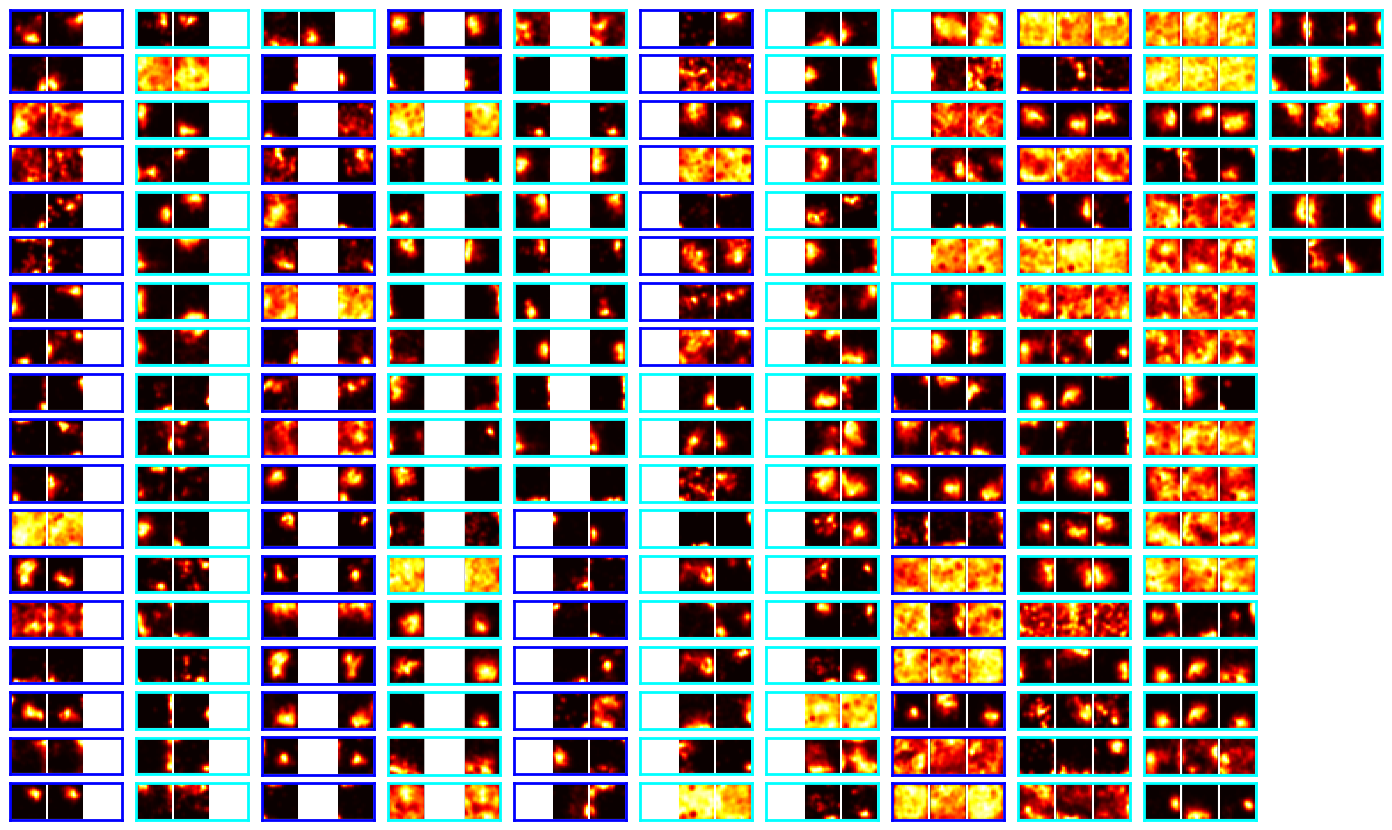

In [53]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify the folder path containing PNG files
folder_path = r"Q:\sachuriga\CR_CA1_paper\Results\Remapping\individual_remaps"  # Replace with your actual folder path

# Collect all PNG files
png_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.png')]
png_files.sort()  # Sort files alphabetically

control_ids = ['65165', '65091', '63383', '66539', '65622']
exp_ids = ['65588', '63385', '66538', '66537', '66922']

# Set A4 size in inches (horizontal orientation: 11.69 x 8.27 inches)
a4_width = 14
a4_height = 8.27

# Create figure
fig = plt.figure(figsize=(a4_width, a4_height))

# Calculate the number of images
n_images = len(png_files)
if n_images == 0:
    print("No PNG files found in the specified folder.")
    plt.close()
else:
    # Define maximum images per column
    max_per_col = 18  # Adjust this based on your preference (number of images per column)
    n_cols = (n_images + max_per_col - 1) // max_per_col  # Ceiling division for number of columns
    
    # Minimize padding (very small values for tight packing)
    col_padding = 0.01  # Reduced padding between columns
    row_padding = 0.01  # Reduced padding between rows
    img_width = (1 - col_padding * (n_cols + 1)) / n_cols
    img_height = (1 - row_padding * (max_per_col + 1)) / max_per_col
    
    # Plot each image
    for i, png_file in enumerate(png_files):
        # Read the image
        group = png_file.split("_")[2]
        img_path = os.path.join(folder_path, png_file)
        img = mpimg.imread(img_path)
        
        # Calculate column and row position (reversed logic)
        col = i // max_per_col
        row = i % max_per_col
        
        # Calculate position
        left = col_padding * (col + 1) + img_width * col
        bottom = row_padding * (max_per_col - row) + img_height * (max_per_col - row - 1)

        # Add axes for each image
        ax = fig.add_axes([left, bottom, img_width, img_height])


        if group == 'control':
            ax.spines['top'].set_color('blue')
            ax.spines['bottom'].set_color('blue')
            ax.spines['left'].set_color('blue')
            ax.spines['right'].set_color('blue')
            ax.spines['top'].set_linewidth(2)
            ax.spines['bottom'].set_linewidth(2)
            ax.spines['left'].set_linewidth(2)
            ax.spines['right'].set_linewidth(2)
        elif group == 'exp':
            ax.spines['top'].set_color('cyan')
            ax.spines['bottom'].set_color('cyan')
            ax.spines['left'].set_color('cyan')
            ax.spines['right'].set_color('cyan')
            ax.spines['top'].set_linewidth(2)
            ax.spines['bottom'].set_linewidth(2)
            ax.spines['left'].set_linewidth(2)
            ax.spines['right'].set_linewidth(2)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])  # Optional: removes the ticks as well
        ax.set_yticks([])
        ax.imshow(img)
        #ax.axis('off')  # Hide axes
    # Remove any extra space around the plot
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
    
    # Display the plot
    plt.show()

    # Optional: Save the figure with tight layout
    # plt.savefig('combined_images.pdf', format='pdf', bbox_inches='tight', pad_inches=0)


2-way ANOVA Results:
                          sum_sq     df          F        PR(>F)
C(Group)                9.870863    2.0  43.011499  4.591901e-17
C(Condition)            0.194919    1.0   1.698688  1.935043e-01
C(Group):C(Condition)   0.078716    2.0   0.342997  7.099311e-01
Residual               32.932330  287.0        NaN           NaN

Bonferroni Corrected Post-hoc Results (showing p < 0.1):
                            Comparison    p_adjusted
3             G1_Control vs G3_Control  1.766234e-04
4        G1_Control vs G3_Experimental  8.874934e-03
7        G1_Experimental vs G3_Control  2.244969e-06
8   G1_Experimental vs G3_Experimental  2.505651e-04
10            G2_Control vs G3_Control  3.098549e-06
11       G2_Control vs G3_Experimental  6.879832e-04
12       G2_Experimental vs G3_Control  6.052822e-10
13  G2_Experimental vs G3_Experimental  3.285625e-08

Within-Group, Across-Condition Comparisons:

Bonferroni Corrected Within-Group Comparisons (showing p < 0.1):
Empty D

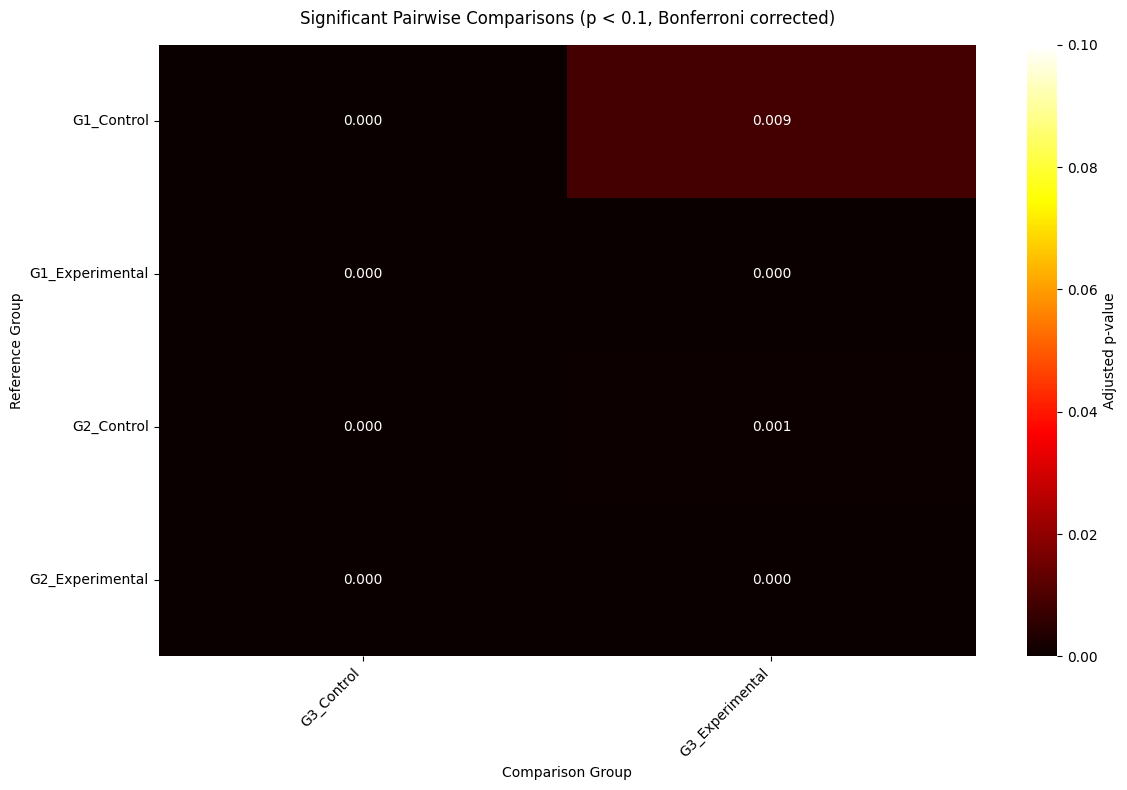

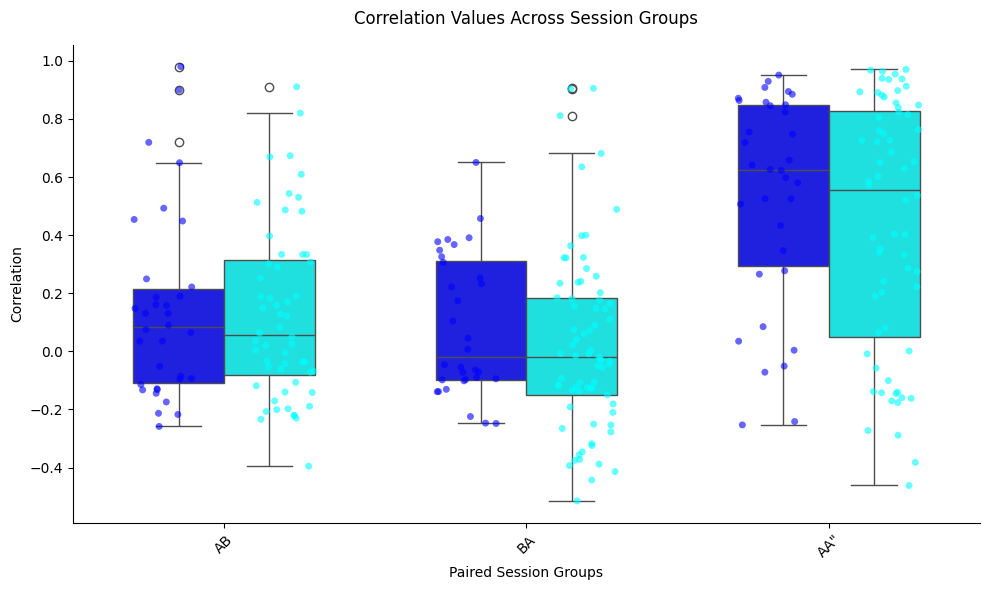

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_ind

pairs_df=pd.read_pickle(r"Q:\sachuriga\CR_CA1_paper\tables/Remapping_ratemaps_unsmoothed.pkl")

# Assuming pairs_df is already defined
df = pairs_df[(pairs_df['cell_type1'] == "pyramidal") 
              & (pairs_df['cell_type2'] == "pyramidal")]

# Define control and experimental animal_ids
control_ids = ['65165', '65091', '63383', '66539', '65622']
exp_ids = ['65588', '63385', '66538', '66537', '66922']

# Split into three groups based on Session1 and Session2
ab_group = df[(df['Session1'] == 1.0) & (df['Session2'] == 2.0)]  # AB group
ba_group = df[(df['Session1'] == 2.0) & (df['Session2'] == 3.0)]  # BA' group
aa_group = df[(df['Session1'] == 1.0) & (df['Session2'] == 3.0)]  # AA' group

# Split into control and experimental groups
control_ab = ab_group[ab_group['animal_id'].isin(control_ids)]
control_ba = ba_group[ba_group['animal_id'].isin(control_ids)]
control_aa = aa_group[aa_group['animal_id'].isin(control_ids)]

exp_ab = ab_group[ab_group['animal_id'].isin(exp_ids)]
exp_ba = ba_group[ba_group['animal_id'].isin(exp_ids)]
exp_aa = aa_group[aa_group['animal_id'].isin(exp_ids)]

# Prepare plotting and analysis data
plot_data = []

# Add control group data
for group_num, group_df in enumerate([control_ab, control_ba, control_aa], 1):
    for corr_value in group_df['Corr']:
        plot_data.append({
            'Corr': corr_value,
            'Group': f'Group{group_num}',
            'Condition': 'Control'
        })

# Add experimental group data
for group_num, group_df in enumerate([exp_ab, exp_ba, exp_aa], 1):
    for corr_value in group_df['Corr']:
        plot_data.append({
            'Corr': corr_value,
            'Group': f'Group{group_num}',
            'Condition': 'Experimental'
        })

# Create DataFrame for plotting and analysis
plot_df = pd.DataFrame(plot_data)

# 2-way ANOVA
model = ols('Corr ~ C(Group) * C(Condition)', data=plot_df).fit()
anova_results = anova_lm(model, typ=2)
print("\n2-way ANOVA Results:")
print(anova_results)

# Get all possible combinations for post-hoc testing
groups = plot_df['Group'].unique()
conditions = plot_df['Condition'].unique()
combinations = [(g, c) for g in groups for c in conditions]

# Calculate means and perform pairwise comparisons
means = plot_df.groupby(['Group', 'Condition'])['Corr'].mean().reset_index()
p_values = []
comparisons = []

# Perform pairwise t-tests for all combinations
for i in range(len(combinations)):
    for j in range(i+1, len(combinations)):
        group1, cond1 = combinations[i]
        group2, cond2 = combinations[j]
        
        data1 = plot_df[(plot_df['Group'] == group1) & 
                       (plot_df['Condition'] == cond1)]['Corr']
        data2 = plot_df[(plot_df['Group'] == group2) & 
                       (plot_df['Condition'] == cond2)]['Corr']
        
        _, p_val = ttest_ind(data1, data2)
        comparisons.append(f"{group1}_{cond1} vs {group2}_{cond2}")
        p_values.append(p_val)

# Apply Bonferroni correction for all comparisons
rejected, p_adjusted, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

# Create p-value DataFrame for heatmap
p_df = pd.DataFrame({
    'Comparison': comparisons,
    'p_value': p_values,
    'p_adjusted': p_adjusted,
    'significant': rejected
})

# Filter for p-values < 0.1 (adjusted)
sig_p_df = p_df[p_df['p_adjusted'] < 0.1].copy()
sig_p_df['Comparison'] = sig_p_df['Comparison'].str.replace('Group', 'G')

# Prepare data for heatmap
pivot_data = {}
for _, row in sig_p_df.iterrows():
    comp = row['Comparison'].split(' vs ')
    if comp[0] not in pivot_data:
        pivot_data[comp[0]] = {}
    pivot_data[comp[0]][comp[1]] = row['p_adjusted']

# Convert to DataFrame
heatmap_df = pd.DataFrame(pivot_data).T
heatmap_df = heatmap_df.fillna(1.0)  # Fill non-significant with 1.0

# Create heatmap
plt.figure(figsize=(12, 8))
mask = heatmap_df >= 0.1  # Mask values >= 0.1
sns.heatmap(
    heatmap_df,
    annot=True,
    cmap='hot',
    mask=mask,
    vmin=0,
    vmax=0.1,
    fmt='.3f',
    cbar_kws={'label': 'Adjusted p-value'}
)

plt.title('Significant Pairwise Comparisons (p < 0.1, Bonferroni corrected)', 
         fontsize=12, pad=15)
plt.xlabel('Comparison Group', fontsize=10)
plt.ylabel('Reference Group', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Print results
print("\nBonferroni Corrected Post-hoc Results (showing p < 0.1):")
print(sig_p_df[['Comparison', 'p_adjusted']])

# New: Within-group, across-condition comparisons (e.g., G1_control vs G1_experimental)
print("\nWithin-Group, Across-Condition Comparisons:")
within_group_comparisons = []
within_group_p_values = []

for group in groups:
    data_control = plot_df[(plot_df['Group'] == group) & 
                         (plot_df['Condition'] == 'Control')]['Corr']
    data_exp = plot_df[(plot_df['Group'] == group) & 
                      (plot_df['Condition'] == 'Experimental')]['Corr']
    
    if len(data_control) > 0 and len(data_exp) > 0:  # Ensure data exists
        _, p_val = ttest_ind(data_control, data_exp)
        within_group_comparisons.append(f"{group}_Control vs {group}_Experimental")
        within_group_p_values.append(p_val)

# Apply Bonferroni correction for within-group comparisons
within_rejected, within_p_adjusted, _, _ = multipletests(within_group_p_values, 
                                                        alpha=0.05, 
                                                        method='bonferroni')

# Create DataFrame for within-group results
within_p_df = pd.DataFrame({
    'Comparison': within_group_comparisons,
    'p_value': within_group_p_values,
    'p_adjusted': within_p_adjusted,
    'significant': within_rejected
})

# Filter significant within-group comparisons
sig_within_p_df = within_p_df[within_p_df['p_adjusted'] < 0.1].copy()
sig_within_p_df['Comparison'] = sig_within_p_df['Comparison'].str.replace('Group', 'G')

# Print within-group results
print("\nBonferroni Corrected Within-Group Comparisons (showing p < 0.1):")
print(sig_within_p_df[['Comparison', 'p_adjusted']])

plt.show()

# Create boxplot without grid and hide top/right axes
plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='Corr', hue='Condition', data=plot_df,
           palette={'Control': 'blue', 'Experimental': 'cyan'}, width=0.6)
sns.stripplot(x='Group', y='Corr', hue='Condition', data=plot_df,
             palette={'Control': 'blue', 'Experimental': 'cyan'},
             dodge=True, size=5, alpha=0.6, jitter=0.2)

plt.grid(False)  # Remove grid
plt.gca().spines['top'].set_visible(False)  # Hide top spine
plt.gca().spines['right'].set_visible(False)  # Hide right spine
plt.title('Correlation Values Across Session Groups', fontsize=12, pad=15)
plt.xlabel('Paired Session Groups', fontsize=10)
plt.ylabel('Correlation', fontsize=10)
plt.legend().set_visible(False)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title='Condition')
plt.legend().set_visible(False)
plt.xticks([0, 1, 2], 
          ['AB', 'BA', 'AA"'],
          rotation=45)
plt.tight_layout()
plt.show()

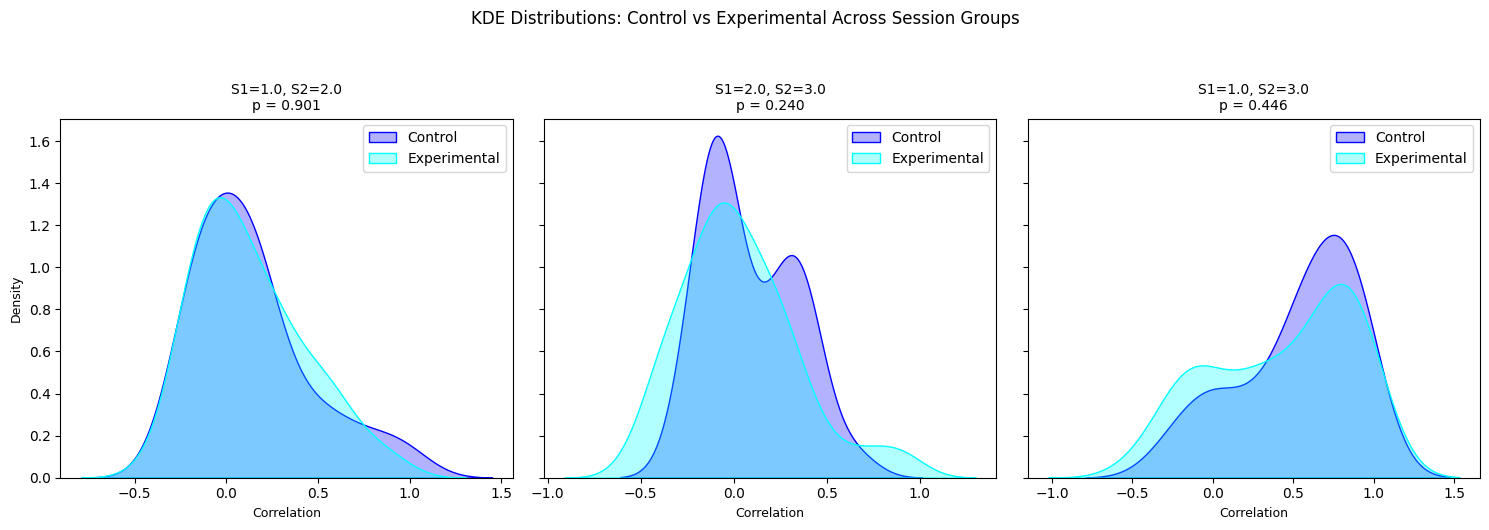


Statistical Test Results (Kolmogorov-Smirnov test):

S1=1.0, S2=2.0:
KS statistic: 0.12
p-value: 0.9005
Control n: 34, Experimental n: 56
No significant difference between Control and Experimental (p >= 0.05)

S1=2.0, S2=3.0:
KS statistic: 0.21
p-value: 0.2402
Control n: 32, Experimental n: 73
No significant difference between Control and Experimental (p >= 0.05)

S1=1.0, S2=3.0:
KS statistic: 0.17
p-value: 0.4456
Control n: 34, Experimental n: 64
No significant difference between Control and Experimental (p >= 0.05)


In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# 假设你的数据已经加载到 DataFrame 中，命名为 df
df = pairs_df[(pairs_df['cell_type1']=="pyramidal") 
                      & (pairs_df['cell_type2']=="pyramidal")] 

# 定义控制组和实验组的 animal_ids
control_ids = ['65165', '65091', '63383', '66539', '65622']
exp_ids = ['65588', '63385', '66538', '66537', '66922']

# 根据 Session1 和 Session2 分成三组
ab_group = df[(df['Session1'] == 1.0) & (df['Session2'] == 2.0)]  # AB组
ba_group = df[(df['Session1'] == 2.0) & (df['Session2'] == 3.0)]  # BA'组
aa_group = df[(df['Session1'] == 1.0) & (df['Session2'] == 3.0)]  # AA'组

# 根据 animal_id 分成 control 和 experimental 组
control_ab = ab_group[ab_group['animal_id'].isin(control_ids)]
control_ba = ba_group[ba_group['animal_id'].isin(control_ids)]
control_aa = aa_group[aa_group['animal_id'].isin(control_ids)]

exp_ab = ab_group[ab_group['animal_id'].isin(exp_ids)]
exp_ba = ba_group[ba_group['animal_id'].isin(exp_ids)]
exp_aa = aa_group[aa_group['animal_id'].isin(exp_ids)]

# 准备绘图数据
plot_data = []

# 添加 control 组数据
for group_num, group_df in enumerate([control_ab, control_ba, control_aa], 1):
    for corr_value in group_df['Corr']:
        plot_data.append({
            'Corr': corr_value,
            'Group': f'Group{group_num}',
            'Condition': 'Control'
        })

# 添加 experimental 组数据
for group_num, group_df in enumerate([exp_ab, exp_ba, exp_aa], 1):
    for corr_value in group_df['Corr']:
        plot_data.append({
            'Corr': corr_value,
            'Group': f'Group{group_num}',
            'Condition': 'Experimental'
        })

# 创建绘图用的 DataFrame
plot_df = pd.DataFrame(plot_data)

# 创建包含三个子图的图形
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
axes = [ax1, ax2, ax3]
group_labels = ['S1=1.0, S2=2.0', 'S1=2.0, S2=3.0', 'S1=1.0, S2=3.0']

# 进行统计检验并绘制 KDE 图
for i, group in enumerate(['Group1', 'Group2', 'Group3']):
    # 获取当前组的数据
    control_data = plot_df[(plot_df['Group'] == group) & (plot_df['Condition'] == 'Control')]['Corr']
    exp_data = plot_df[(plot_df['Group'] == group) & (plot_df['Condition'] == 'Experimental')]['Corr']
    
    # 进行 KS 检验
    statistic, p_value = ks_2samp(control_data, exp_data)
    
    # 绘制 KDE 图
    sns.kdeplot(data=control_data, ax=axes[i], color='blue', label='Control', fill=True, alpha=0.3)
    sns.kdeplot(data=exp_data, ax=axes[i], color='cyan', label='Experimental', fill=True, alpha=0.3)
    
    # 自定义每个子图
    axes[i].set_title(f'{group_labels[i]}\np = {p_value:.3f}', fontsize=10)
    axes[i].set_xlabel('Correlation', fontsize=9)
    if i == 0:
        axes[i].set_ylabel('Density', fontsize=9)
    axes[i].legend()

# 调整布局
plt.suptitle('KDE Distributions: Control vs Experimental Across Session Groups', 
             fontsize=12, y=1.05)
plt.tight_layout()

# 显示图表
plt.show()

# 打印详细统计结果
print("\nStatistical Test Results (Kolmogorov-Smirnov test):")
for i, group in enumerate(['Group1', 'Group2', 'Group3']):
    control_data = plot_df[(plot_df['Group'] == group) & (plot_df['Condition'] == 'Control')]['Corr']
    exp_data = plot_df[(plot_df['Group'] == group) & (plot_df['Condition'] == 'Experimental')]['Corr']
    statistic, p_value = ks_2samp(control_data, exp_data)
    print(f"\n{group_labels[i]}:")
    print(f"KS statistic: {statistic:.2f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Control n: {len(control_data)}, Experimental n: {len(exp_data)}")
    if p_value < 0.05:
        print("Significant difference between Control and Experimental (p < 0.05)")
    else:
        print("No significant difference between Control and Experimental (p >= 0.05)")

C:\Users\sachur\AppData\Local\Temp\ipykernel_5136\915396197.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


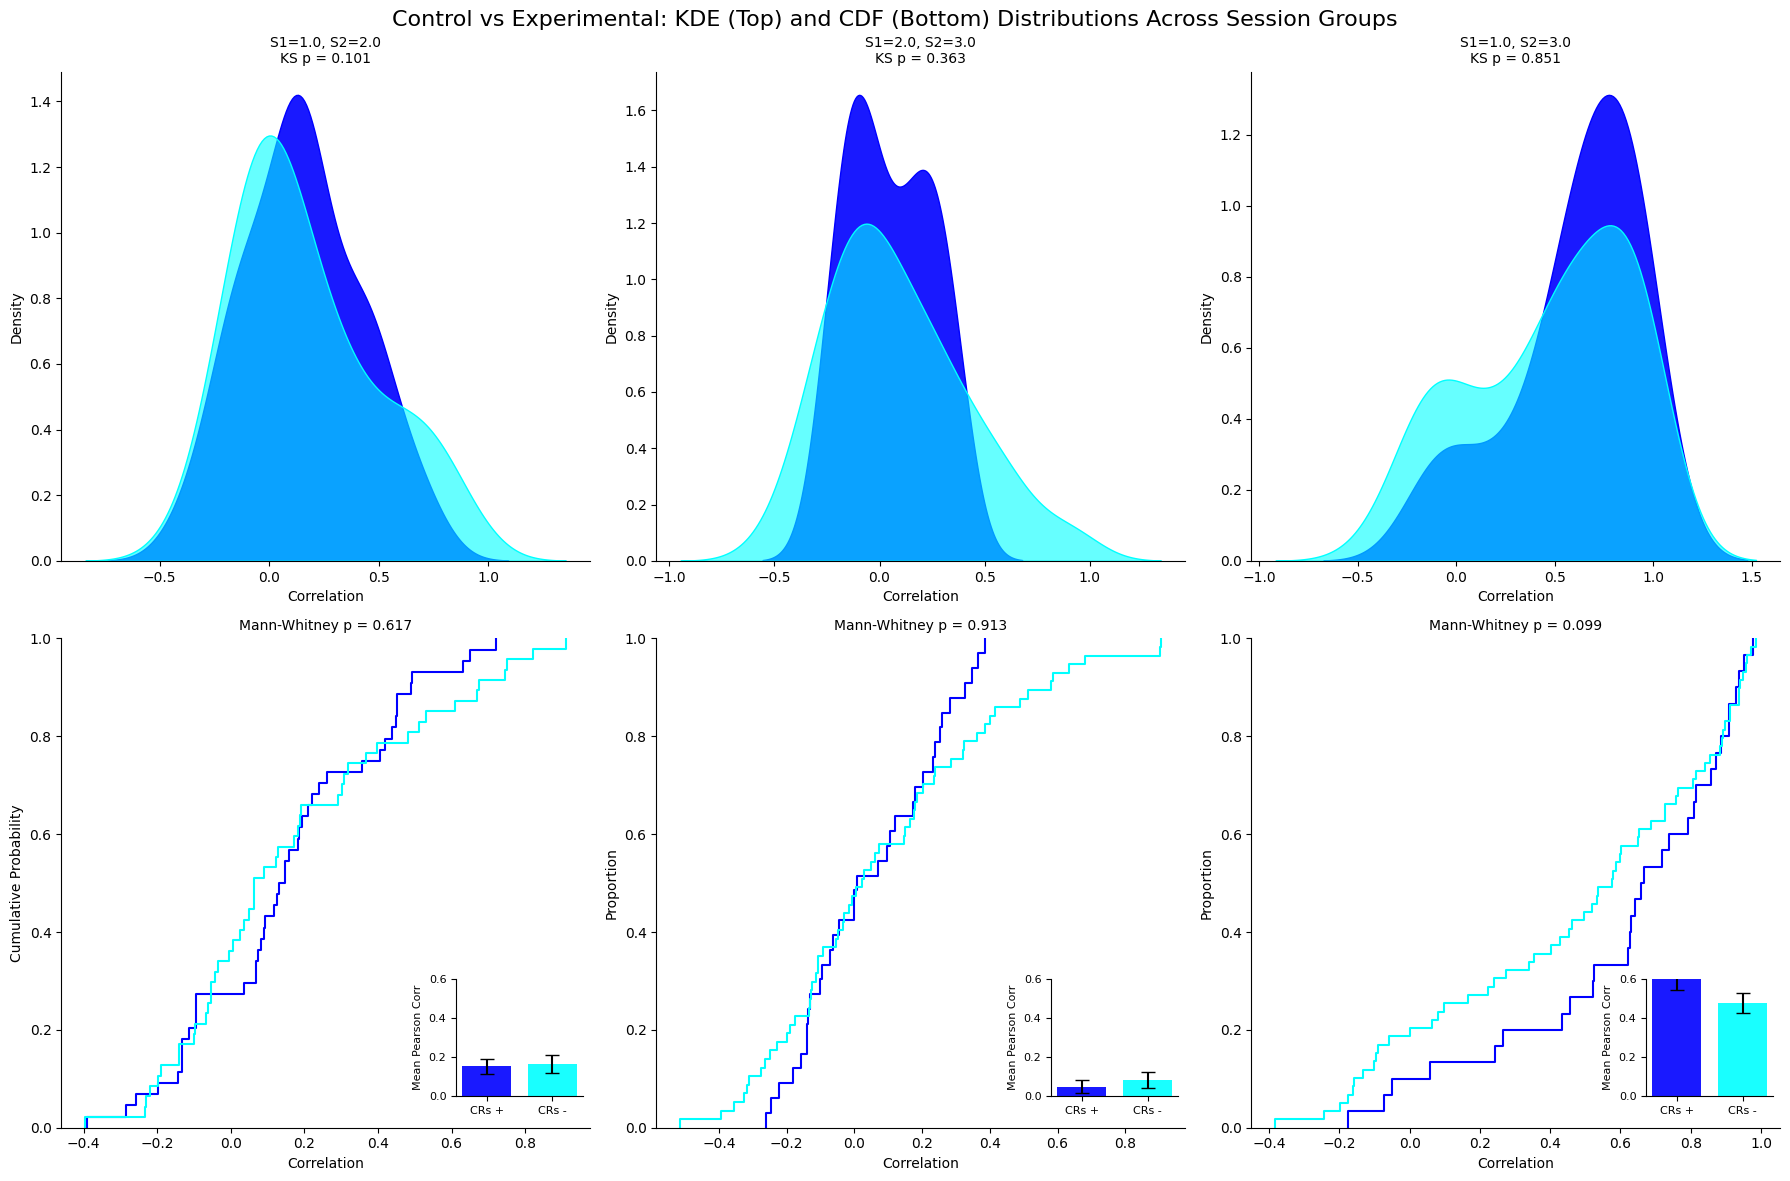

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Statistical Test Results:

S1=1.0, S2=2.0:
Kolmogorov-Smirnov Test:
KS statistic: 0.22
p-value: 0.1012
Alternative hypothesis: less

Mann-Whitney U Test:
U statistic: 1071.00
p-value: 0.6171
Alternative hypothesis: less

Control n: 44, Experimental n: 47
No significant difference between Control and Experimental (p >= 0.05)

S1=2.0, S2=3.0:
Kolmogorov-Smirnov Test:
KS statistic: 0.19
p-value: 0.3627
Alternative hypothesis: two-sided

Mann-Whitney U Test:
U statistic: 927.00
p-value: 0.9133
Alternative hypothesis: two-sided

Control n: 33, Experimental n: 57
No significant difference between Control and Experimental (p >= 0.05)

S1=1.0, S2=3.0:
Kolmogorov-Smirnov Test:
KS statistic: 0.05
p-value: 0.8511
Alternative hypothesis: greater

Mann-Whitney U Test:
U statistic: 1034.00
p-value: 0.0987
Alternative hypothesis: greater

Control n: 30, Experimental n: 59
No significant difference between Control and Experimental (p >= 0.05)


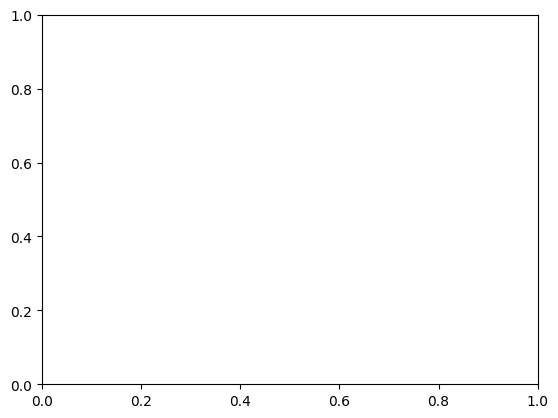

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, mannwhitneyu
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

pairs_df=pd.read_pickle(r"Q:\sachuriga\CR_CA1_paper\tables/Remapping_ratemaps_unsmoothed.pkl")
# Assuming your data is loaded in pairs_df
df = pairs_df[(pairs_df['cell_type1']=="pyramidal") 
              & (pairs_df['cell_type2']=="pyramidal")]

# df = pairs_df[(pairs_df['functional cell type1']=='place cell') 
#               | (pairs_df['functional cell type2']=='place cell')]


# df = pairs_df[(pairs_df['functional cell type1']!='place cell') &
#               (pairs_df['functional cell type2']!='place cell')]

df = pairs_df[(pairs_df['neuron location 1']=='superficial') &
              (pairs_df['neuron location 2']=='superficial')]

# Define control and experimental animal_ids
control_ids = ['65165', '65091', '63383', '66539', '65622']
exp_ids = ['65588', '63385', '66538', '66537', '66922']

# Split into three groups based on Session1 and Session2
ab_group = df[(df['Session1'] == 1.0) & (df['Session2'] == 2.0)]  # AB group
ba_group = df[(df['Session1'] == 2.0) & (df['Session2'] == 3.0)]  # BA' group
aa_group = df[(df['Session1'] == 1.0) & (df['Session2'] == 3.0)]  # AA' group

# Split into control and experimental groups
control_ab = ab_group[ab_group['animal_id'].isin(control_ids)]
control_ba = ba_group[ba_group['animal_id'].isin(control_ids)]
control_aa = aa_group[aa_group['animal_id'].isin(control_ids)]

exp_ab = ab_group[ab_group['animal_id'].isin(exp_ids)]
exp_ba = ba_group[ba_group['animal_id'].isin(exp_ids)]
exp_aa = aa_group[aa_group['animal_id'].isin(exp_ids)]

# Prepare plotting data
plot_data = []

# Add control group data
for group_num, group_df in enumerate([control_ab, control_ba, control_aa], 1):
    for corr_value in group_df['Corr']:
        plot_data.append({
            'Corr': corr_value,
            'Group': f'Group{group_num}',
            'Condition': 'Control'
        })

# Add experimental group data
for group_num, group_df in enumerate([exp_ab, exp_ba, exp_aa], 1):
    for corr_value in group_df['Corr']:
        plot_data.append({
            'Corr': corr_value,
            'Group': f'Group{group_num}',
            'Condition': 'Experimental'
        })

# Create DataFrame for plotting
plot_df = pd.DataFrame(plot_data)

# Create single figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 12), height_ratios=[1, 1])
axes_kde = axes[0, :]  # First row for KDE
axes_cdf = axes[1, :]  # Second row for CDF

group_labels = ['S1=1.0, S2=2.0', 'S1=2.0, S2=3.0', 'S1=1.0, S2=3.0']
alternatives = ['less', 'two-sided', 'greater']  # AB: Exp > Control, BA': two-sided, AA': Exp < Control

# Perform statistical tests and create plots
for i, group in enumerate(['Group1', 'Group2', 'Group3']):
    # Get data for current group
    control_data = plot_df[(plot_df['Group'] == group) & (plot_df['Condition'] == 'Control')]['Corr']
    exp_data = plot_df[(plot_df['Group'] == group) & (plot_df['Condition'] == 'Experimental')]['Corr']
    
    # Perform KS test
    ks_statistic, ks_p_value = ks_2samp(control_data, exp_data, alternative=alternatives[i])
    
    # Perform Mann-Whitney U test
    mw_statistic, mw_p_value = mannwhitneyu(control_data, exp_data, alternative=alternatives[i])
    
    # Plot KDE (first row)
    sns.kdeplot(data=control_data, ax=axes_kde[i], color='blue', label='Control', fill=True, alpha=0.9)
    sns.kdeplot(data=exp_data, ax=axes_kde[i], color='cyan', label='Experimental', fill=True, alpha=0.6)
    
    # Plot CDF (second row)
    sns.ecdfplot(data=control_data, ax=axes_cdf[i], color='blue', label='Control')
    sns.ecdfplot(data=exp_data, ax=axes_cdf[i], color='cyan', label='Experimental')
    
    # Customize KDE subplot
    axes_kde[i].set_title(f'{group_labels[i]}\nKS p = {ks_p_value:.3f}', fontsize=10)
    axes_kde[i].set_xlabel('Correlation', fontsize=10)
    if i == 0:
        axes_kde[i].set_ylabel('Density', fontsize=10)
    axes_kde[i].legend()
    axes_kde[i].grid(False)
    axes_kde[i].set_aspect('auto')
    axes_kde[i].spines['right'].set_visible(False)
    axes_kde[i].spines['top'].set_visible(False)
    axes_kde[i].legend().set_visible(False)
    # Customize CDF subplot
    axes_cdf[i].set_title(f'Mann-Whitney p = {mw_p_value:.3f}', fontsize=10)
    axes_cdf[i].set_xlabel('Correlation', fontsize=10)
    if i == 0:
        axes_cdf[i].set_ylabel('Cumulative Probability', fontsize=10)
    axes_cdf[i].legend()
    axes_cdf[i].grid(False)
    axes_cdf[i].set_aspect('auto')
    axes_cdf[i].spines['right'].set_visible(False)
    axes_cdf[i].spines['top'].set_visible(False)
    axes_cdf[i].legend().set_visible(False)


        # Calculate means and SEM
    control_mean = np.mean(control_data)
    exp_mean = np.mean(exp_data)
    control_sem = stats.sem(control_data)
    exp_sem = stats.sem(exp_data)

    # Create inset axes for bar plot in top-right corner
    inset_ax = inset_axes(axes_cdf[i], width="80%", height="80%", loc='lower right',
                     bbox_to_anchor=(0.7, 0.05, 0.3, 0.3),  # 4-tuple: x0, y0, width, height
                     bbox_transform=axes[1, i].transAxes)
    
    inset_ax.bar([0.2, 0.8], [control_mean, exp_mean], yerr=[control_sem, exp_sem], 
                 color=['blue', 'cyan'], alpha=0.9, width=0.45, capsize=5)
    inset_ax.set_xticks([0.2, 0.8])
    inset_ax.set_xticklabels(['CRs +', 'CRs -'], fontsize=8)
    inset_ax.set_ylabel('Mean Pearson Corr', fontsize=8)
    inset_ax.tick_params(axis='both', labelsize=8)
    inset_ax.spines['top'].set_visible(False)
    inset_ax.spines['right'].set_visible(False)
    inset_ax.set_ylim([0, 0.6])

# Adjust layout
plt.suptitle('Control vs Experimental: KDE (Top) and CDF (Bottom) Distributions Across Session Groups', 
             fontsize=16)
plt.tight_layout()

# Display plot
plt.show()
plt.legend().set_visible(False)
# Print statistical results
print("\nStatistical Test Results:")
for i, group in enumerate(['Group1', 'Group2', 'Group3']):
    control_data = plot_df[(plot_df['Group'] == group) & (plot_df['Condition'] == 'Control')]['Corr']
    exp_data = plot_df[(plot_df['Group'] == group) & (plot_df['Condition'] == 'Experimental')]['Corr']
    
    # KS test
    ks_statistic, ks_p_value = ks_2samp(control_data, exp_data, alternative=alternatives[i])
    
    # Mann-Whitney U test
    mw_statistic, mw_p_value = mannwhitneyu(control_data, exp_data, alternative=alternatives[i])
    
    print(f"\n{group_labels[i]}:")
    print("Kolmogorov-Smirnov Test:")
    print(f"KS statistic: {ks_statistic:.2f}")
    print(f"p-value: {ks_p_value:.4f}")
    print(f"Alternative hypothesis: {alternatives[i]}")
    
    print("\nMann-Whitney U Test:")
    print(f"U statistic: {mw_statistic:.2f}")
    print(f"p-value: {mw_p_value:.4f}")
    print(f"Alternative hypothesis: {alternatives[i]}")
    
    print(f"\nControl n: {len(control_data)}, Experimental n: {len(exp_data)}")
    if ks_p_value < 0.05 or mw_p_value < 0.05:
        print("Significant difference between Control and Experimental (p < 0.05)")
    else:
        print("No significant difference between Control and Experimental (p >= 0.05)")

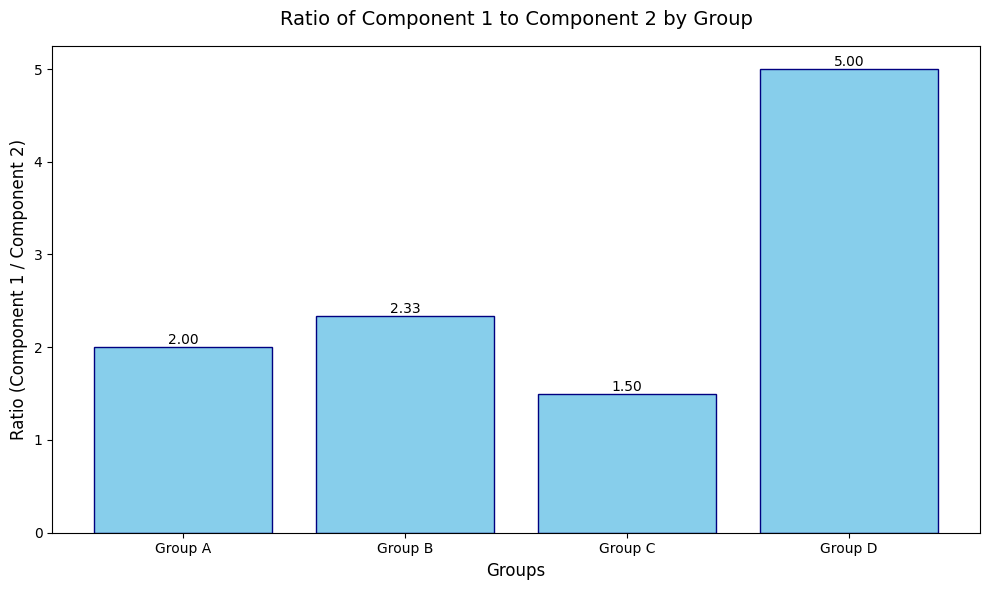

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
groups = ['Group A', 'Group B', 'Group C', 'Group D']
component1 = [20, 35, 30, 25]  # Values for component 1
component2 = [10, 15, 20, 5]   # Values for component 2

# Calculate ratios
ratios = [c1 / c2 for c1, c2 in zip(component1, component2)]

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(groups, ratios, color='skyblue', edgecolor='navy')

# Customize the plot
plt.title('Ratio of Component 1 to Component 2 by Group', fontsize=14, pad=15)
plt.xlabel('Groups', fontsize=12)
plt.ylabel('Ratio (Component 1 / Component 2)', fontsize=12)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

In [ ]:

def collect_remap(base_folder,animal,day,pairs_df,df,identifier,df_loaded_cell_type = None,plot=False,):
    import pandas as pd
    #df = pd.read_csv(rf'S:\Sachuriga/Ephys_Recording/CR_CA1/{animal}/{animal}_{day}_unitmatchResults/MatchTable.csv')
    # df1 = df[df['Matches']==1]
    # df1 

    df2 = df[(df['UM Probabilities']>0.8)&(df['Matches']==1)]
    #df2 = df[df['Matches']==1]

    # for i in range(4):
    #     temp_df.append(df2[(df2['RecSes 1'] == i) & (df2['RecSes 2'] !=i)])
    # df_s=pd.concat(temp_df, ignore_index=True)
    all_temp_rows = []
    temp_all_temp_rows=[]
    temp_df=[]

    i=1
    temp_df.append(df2[(df2['RecSes 1'] == i) & (df2['RecSes 2'] !=i)])
    df_s=pd.concat(temp_df, ignore_index=True)
    match_sessions = np.unique(df_s['RecSes 2'])
    for s in match_sessions:
        temp_df = df_s[df_s['RecSes 2']==s]
        for i in np.unique(temp_df['ID2']):
            temp_id_df = temp_df[temp_df['ID2']==i].sort_values(by='UM Probabilities',ascending=False)
            temp_row = temp_id_df.head(1)
            temp_all_temp_rows.append(temp_row)
        
        temp_df = pd.concat(temp_all_temp_rows, ignore_index=True)
        temp_df = temp_df[(temp_df['RecSes 2']==s)&(temp_df['RecSes 1']==1)]

        for i in np.unique(temp_df['ID1']):
            temp_id_df = temp_df[temp_df['ID1']==i].sort_values(by='UM Probabilities',ascending=False)
            temp_row = temp_id_df.head(1)
            all_temp_rows.append(temp_row)

    #     temp_df = pd.concat(temp_all_temp_rows, ignore_index=True)
    #     for i in np.unique(temp_df['ID2']):
    #         temp_id_df = temp_df[temp_df['ID2']==i].sort_values(by='UM Probabilities',ascending=False)
    #         temp_row = temp_id_df.head(1)
    #         all_temp_rows.append(temp_row)

    temp_all_temp_rows=[]
    if len(match_sessions)>=2:
        print("here")
        df_s2 = df2[(df2['RecSes 1'] == match_sessions[0]) & (df2['RecSes 2'] == match_sessions[1])]
        for j in np.unique(df_s2['ID1']):
            temp_id_dfs2 = df_s2[df_s2['ID1']==j].sort_values(by='UM Probabilities',ascending=False)
            temp_rows = temp_id_dfs2.head(1)
            temp_all_temp_rows.append(temp_rows)

        temp_df = pd.concat(temp_all_temp_rows, ignore_index=True)
        for j in np.unique(df_s2['ID2']):
            temp_id_dfs2 = df_s2[df_s2['ID2']==j].sort_values(by='UM Probabilities',ascending=False)
            temp_rows = temp_id_dfs2.head(1)
            all_temp_rows.append(temp_rows)


    match_sessions = pd.concat(all_temp_rows, ignore_index=True)
    new_df = match_sessions

    import pandas as pd
    pd.set_option('display.max_rows', None)
    np.set_printoptions(threshold=np.inf)

    session_data = []
    files = find_nwb_files(base_folder, animal, day)
    pkl_base_folder = r"S:\Sachuriga\filre_with_table\adjust_y_with _meanVAlue\clusters_with_tsneLabel\ripple_max\ripple_py"
    pkl_files = find_pkl_files(pkl_base_folder, animal, day)
    session_pkl_data = []
    for file in pkl_files:
        session_pkl_data.append(pd.read_pickle(file))
        print(file)


    for file in files:
        session_data.append(nap.load_file(file))
        print(file)
    
    pairs_df = plot_remap(new_df,session_data,session_pkl_data,pairs_df,identifier,animal,df_loaded_cell_type = df_loaded_cell_type, plot=False)
    return pairs_df

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pynapple.core.metadata_class")

def plot_remap(new_df,session_data,session_pkl_data,pairs_df,identifier, animal, df_loaded_cell_type = None, plot=False):
    # 假设数据结构：
    # new_df: 包含列 ['RecSes 1', 'RecSes 2', 'ID1', 'ID2', 'UM Probabilities']
    # session_data: {1: 数据1, 2: 数据2, 3: 数据3}

    # pairs_df = pd.DataFrame(columns=['Session1', 'Session2', 'ID1', 'ID2', 
    #                                 'cell_type', 'quality', 'functional cell type', 
    #                                 'Corr', 'Coherence1', 'Coherence2'])
    
    pair_data = []
    if len(session_data)==3:
        # Step 1: 筛选 Session 1 → Session 2 和 Session 2 → Session 3 的配对
        A = new_df[(new_df['RecSes 1'] == 1) & (new_df['RecSes 2'] == 2)]
        B = new_df[(new_df['RecSes 1'] == 2) & (new_df['RecSes 2'] == 3)]

        # Step 2: 通过合并 A 和 B 找到三联体
        merged = pd.merge(A, B, left_on='ID2', right_on='ID1', suffixes=('_A', '_B'))

        # Step 3: 绘制三联体并记录配对
        triplet_pairs = set()  # 存储三联体中的配对

        for index, row in merged.iterrows():
            identifier += 1
            # 三联体的单元 ID
            id1_s1 = row['ID1_A']  # Session 1
            id2_s2 = row['ID2_A']  # Session 2
            id2_s3 = row['ID2_B']  # Session 3
            
            # 获取会话数据
            data1 = session_data[0]
            data2 = session_data[1]
            data3 = session_data[2]
            
            data_pkl1 = session_pkl_data[0]
            data_pkl2 = session_pkl_data[1]
            data_pkl3 = session_pkl_data[2]
            
            if (data1['units']['unit_name'][np.int32(id1_s1)] in data_pkl1['unit_name'].values) and \
                (data2['units']['unit_name'][np.int32(id2_s2)] in data_pkl2['unit_name'].values) and \
                (data3['units']['unit_name'][np.int32(id2_s3)] in data_pkl3['unit_name'].values):
                    # Your code here
                # 创建 1x3 subplot
                if plot:
                    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

                    # 绘制 Session 1
                    rate_map1,t1,t12,t13 = plot_place_cells(data1, data_pkl1,unit_num=id1_s1, df_loaded_cell_type=df_loaded_cell_type,ax=ax1)
                    coherence1 = coherence(rate_map1)

                    # 绘制 Session 2
                    rate_map2,t2,t22,t23 = plot_place_cells(data2,data_pkl2, unit_num=id2_s2, df_loaded_cell_type=df_loaded_cell_type, ax=ax2)
                    coherence2 = coherence(rate_map2)
                    # 绘制 Session 3
                    rate_map3,t3,t32,t33 = plot_place_cells(data3,data_pkl3, unit_num=id2_s3, df_loaded_cell_type=df_loaded_cell_type, ax=ax3)
                    coherence3 = coherence(rate_map3)

                else:
                                    # 绘制 Session 1
                    rate_map1,t1,t12,t13,t14 = plot_place_cells(data1,data_pkl1, unit_num=id1_s1, df_loaded_cell_type=df_loaded_cell_type)
                    coherence1 = coherence(rate_map1)

                    # 绘制 Session 2
                    rate_map2,t2,t22,t23,t24 = plot_place_cells(data2, data_pkl2,unit_num=id2_s2, df_loaded_cell_type=df_loaded_cell_type)
                    coherence2 = coherence(rate_map2)
                    # 绘制 Session 3
                    rate_map3,t3,t32,t33,t34 = plot_place_cells(data3, data_pkl3,unit_num=id2_s3, df_loaded_cell_type=df_loaded_cell_type)
                    coherence3 = coherence(rate_map3)


                # 计算相关性
                corr12 = calculate_spatial_stability(rate_map1, rate_map2)
                corr23 = calculate_spatial_stability(rate_map2, rate_map3)
                corr13 = calculate_spatial_stability(rate_map1, rate_map3)
                # 添加标题
                if plot:
                    ax1.set_title(f'RecSes 1,{t1}, Unit {id1_s1}\nCoherence: {coherence1:.3f}, quality: {t13}')
                    ax2.set_title(f'RecSes 2,{t2}, Unit {id2_s2}\nCoherence: {coherence2:.3f}, quality: {t23}')
                    ax3.set_title(f'RecSes 3,{t2}, Unit {id2_s3}\nCoherence: {coherence3:.3f}, quality: {t33}')
                    fig.suptitle(f'Triplet: (1, {id1_s1}) - (2, {id2_s2}) - (3, {id2_s3})\n'
                                f'Corr 1-2: {corr12:.6f}, Corr 2-3: {corr23:.6f},Corr 1-3: {corr13:.6f}')
                    
                    plt.tight_layout(rect=[0, 0, 1, 0.95])
                    plt.show()
                rate_maps = []
                rate_maps.append(rate_map1)
                rate_maps.append(rate_map2)
                rate_maps.append(rate_map3)
                # 记录三联体中的配对
                print(fr"cell1 {t1} cell2 {t2} cell3 {t3}")
                
                #if t1==t2==t3=="pyramidal":
                triplet_pairs.add((1, 2, id1_s1, id2_s2))  # Session 1 → Session 2
                pair_data.append({
                        'Session1': 1, 'Session2': 2, 'ID1': id1_s1, 'ID2':id2_s2,
                        'cell_type1':t1, 'cell_type2':t2, 'quality1':t13, 'quality2':t23,'functional cell type1':t12,'functional cell type2':t22, 'neuron location 1':t14,'neuron location 2':t24, 
                        'Corr':corr12,'identifier':identifier,'animal_id':animal})

                triplet_pairs.add((2, 3, id2_s2, id2_s3))  # Session 2 → Session 3
                pair_data.append({
                        'Session1': 2, 'Session2': 3, 'ID1': id2_s2, 'ID2':id2_s3,
                        'cell_type1':t2, 'cell_type2':t3, 'quality1':t23, 'quality2':t33,'functional cell type1':t22,'functional cell type2':t32, 'neuron location 1':t24,'neuron location 2':t34, 
                        'Corr':corr23,'identifier':identifier,'animal_id':animal})
                triplet_pairs.add((1, 3, id1_s1, id2_s3)) 
                pair_data.append({
                        'Session1': 1, 'Session2': 3, 'ID1': id1_s1, 'ID2':id2_s3,
                        'cell_type1':t1, 'cell_type2':t3, 'quality1':t13, 'quality2':t33,'functional cell type1':t12,'functional cell type2':t32, 'neuron location 1':t14,'neuron location 2':t34,  
                        'Corr':corr13,'identifier':identifier,'animal_id':animal, 'rate_maps': rate_maps})
                print(triplet_pairs)

            # Step 4: 绘制二联体，跳过在三联体中出现过的配对
        for index, row in new_df.iterrows():
            identifier += 1
            rec_ses1, rec_ses2 = row['RecSes 1'], row['RecSes 2']
            id1, id2 = row['ID1'], row['ID2']
            prob = row['UM Probabilities']
            
            # 检查当前配对是否在三联体中
            current_pair = (rec_ses1, rec_ses2, id1, id2)
            if current_pair in triplet_pairs:
                continue  # 跳过
            print(current_pair)
            # 获取数据
            
            data1 = session_data[np.int64(rec_ses1)-1]
            data2 = session_data[np.int64(rec_ses2)-1]

            data_pkl1 = session_pkl_data[np.int64(rec_ses1)-1]
            data_pkl2 = session_pkl_data[np.int64(rec_ses2)-1]

            if (data1['units']['unit_name'][np.int32(id1)] in data_pkl1['unit_name'].values) and \
                (data2['units']['unit_name'][np.int32(id2)] in data_pkl2['unit_name'].values):
                # 创建 1x2 subplot
                if plot:
                    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
                
                    # 绘制第一个 place cell
                    rate_map1,t1,t12,t13,t14 = plot_place_cells(data1, data_pkl1, unit_num=id1, df_loaded_cell_type=df_loaded_cell_type, ax=ax1)
                    coherence1 = coherence(rate_map1)

                    # 绘制第二个 place cell
                    rate_map2,t2,t22,t23,t24 = plot_place_cells(data2, data_pkl2, unit_num=id2, df_loaded_cell_type=df_loaded_cell_type, ax=ax2)
                    coherence2 = coherence(rate_map2)
                else:
                                    # 绘制第一个 place cell
                    rate_map1,t1,t12,t13,t14 = plot_place_cells(data1, data_pkl1, unit_num=id1, df_loaded_cell_type=df_loaded_cell_type)
                    coherence1 = coherence(rate_map1)

                    # 绘制第二个 place cell
                    rate_map2,t2,t22,t23,t24 = plot_place_cells(data2, data_pkl2, unit_num=id2, df_loaded_cell_type=df_loaded_cell_type)
                    coherence2 = coherence(rate_map2)

                rate_maps = []
                rate_maps.append(rate_map1)
                rate_maps.append(rate_map2)
                # 计算相关性
                correlation = calculate_spatial_stability(rate_map1, rate_map2)
                
                #if t1==t2=="pyramidal":
                pair_data.append({
                        'Session1': rec_ses1, 'Session2': rec_ses2, 'ID1': id1, 'ID2':id2,
                        'cell_type1':t1, 'cell_type2':t2, 'quality1':t13, 'quality2':t23,'functional cell type1':t12,'functional cell type2':t22, 'neuron location 1':t14,'neuron location 2':t24, 
                        'Corr':correlation,'identifier':identifier,'animal_id':animal,'rate_maps':rate_maps})
                
                # 添加标题
                if plot:
                    ax1.set_title(f'RecSes {rec_ses1},{t1}, Unit {id1}\nCoherence: {coherence1:.3f}, quality: {t13}')
                    ax2.set_title(f'RecSes {rec_ses2},{t2}, Unit {id2}\nCoherence: {coherence2:.3f}, quality: {t23}')
                    fig.suptitle(f'Pair: ({rec_ses1}, {id1}) - ({rec_ses2}, {id2}), '
                                f'UM Probability: {prob:.6f}, Correlation: {correlation:.6f}')
                    
                    plt.tight_layout(rect=[0, 0, 1, 0.95])
                    plt.show()
    else:
       
        triplet_pairs = set()
        # Step 4: 绘制二联体，跳过在三联体中出现过的配对
        for index, row in new_df.iterrows():
            identifier += 1
            rec_ses1, rec_ses2 = row['RecSes 1'], row['RecSes 2']
            id1, id2 = row['ID1'], row['ID2']
            prob = row['UM Probabilities']
            
            # 检查当前配对是否在三联体中
            current_pair = (rec_ses1, rec_ses2, id1, id2)
            if current_pair in triplet_pairs:
                continue  # 跳过
            
            # 获取数据
            data1 = session_data[np.int64(rec_ses1)-1]
            data2 = session_data[np.int64(rec_ses2)-1]
            data_pkl1 = session_pkl_data[np.int64(rec_ses1)-1]
            data_pkl2 = session_pkl_data[np.int64(rec_ses2)-1]
            if (data1['units']['unit_name'][np.int32(id1)] in data_pkl1['unit_name'].values) and \
                (data2['units']['unit_name'][np.int32(id2)] in data_pkl2['unit_name'].values):
                # 创建 1x2 subplot
                if plot:
                    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
                
                    # 绘制第一个 place cell
                    rate_map1,t1,t12,t13,t14 = plot_place_cells(data1, data_pkl1, unit_num=id1, df_loaded_cell_type=df_loaded_cell_type, ax=ax1)
                    coherence1 = coherence(rate_map1)
                    
                    
                    # 绘制第二个 place cell
                    rate_map2,t2,t22,t23,t24 = plot_place_cells(data2, data_pkl2, unit_num=id2, df_loaded_cell_type=df_loaded_cell_type, ax=ax2)
                    coherence2 = coherence(rate_map2)
                else:
                                    # 绘制第一个 place cell
                    rate_map1,t1,t12,t13,t14 = plot_place_cells(data1, data_pkl1, unit_num=id1, df_loaded_cell_type=df_loaded_cell_type)
                    coherence1 = coherence(rate_map1)
                    
                    
                    # 绘制第二个 place cell
                    rate_map2,t2,t22,t23,t24 = plot_place_cells(data2, data_pkl2, unit_num=id2, df_loaded_cell_type=df_loaded_cell_type)
                    coherence2 = coherence(rate_map2)
                    
                rate_maps = []
                rate_maps.append(rate_map1)
                rate_maps.append(rate_map2)
                # 计算相关性
                correlation = calculate_spatial_stability(rate_map1, rate_map2)
                #if t1==t2=="pyramidal":
                pair_data.append({
                        'Session1': rec_ses1, 'Session2': rec_ses2, 'ID1': id1, 'ID2':id2,
                        'cell_type1':t1, 'cell_type2':t2, 'quality1':t13, 'quality2':t23,'functional cell type1':t12,'functional cell type2':t22, 'neuron location 1':t14,'neuron location 2':t24, 
                        'Corr':correlation,'identifier':identifier,'animal_id':animal,"rate_maps":rate_maps})
                # 添加标题
                if plot:
                    ax2.set_title(f'RecSes {rec_ses2},{t2},  Unit {id2}\nCoherence: {coherence2:.3f}, quality: {t23}')
                    ax1.set_title(f'RecSes {rec_ses1},{t1},  Unit {id1}\nCoherence: {coherence1:.3f}, quality: {t13}')
                    fig.suptitle(f'Pair: ({rec_ses1}, {id1}) - ({rec_ses2}, {id2}), '
                                f'UM Probability: {prob:.6f}, Correlation: {correlation:.6f}')
                    
                    plt.tight_layout(rect=[0, 0, 1, 0.95])
                    plt.show()
    print("所有三联体和未重复的二联体 place cell 图已生成！")
    print(pd.DataFrame(pairs_df))
    return pd.concat([pairs_df, pd.DataFrame(pair_data)], ignore_index=True)